# Building a predictive model - Part I

[1. Import data (Data Integration)](#1st-bullet)<br>
[2. Explore data (Data Access, Exploration and Understanding)](#2nd-bullet)<br>
[3. Modify data (Data Preparation)](#3rd-bullet)<br>
- [3.1. Feature Selection](#4th-bullet)<br>
    - [3.1.1. Categorical Variables](#5th-bullet)<br>
        - [3.1.1.1. Chi-Square](#6th-bullet)<br>
    - [3.1.2 Numerical Variables](#7th-bullet)<br>
        - [3.1.2.1. Variance](#8th-bullet)<br>
        - [3.1.2.2. Spearman Correlation](#9th-bullet)<br>
        - [3.1.2.3. Feature Importance in Decision Trees](#10th-bullet)<br>
        - [3.1.2.4. Recursive Feature Elimination with Logistic Regression](#11th-bullet)<br>
        - [3.1.2.5. Lasso Regression](#12th-bullet)<br>


<img src="Images/process_ML.png" style="height:70px">

__`Step 1`__ Import all the needed libraries.

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

############################################ FEATURE SELECTION ############################################
#!pip install scipy
import scipy.stats as stats
from scipy.stats import chi2_contingency # filter method
from sklearn.feature_selection import RFE # wrapper method
from sklearn.linear_model import LogisticRegression # (this is one possible model to apply inside RFE)
from sklearn.linear_model import LogisticRegressionCV # embedded method - LassoCV would be used in a regression problem 
from sklearn.tree import DecisionTreeClassifier # embedded method

import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="1st-bullet">

# 1. Import data (Data Integration)

</a>

<img src="Images/step1.png" style="height:70px">

__`Step 2`__ Import the train dataset and define the index as the `Custid`.

In [2]:
data = pd.read_excel(r'Data/data.xlsx')
data.set_index('Custid', inplace = True)
data

,Year_Birth,Gender,Education,Marital_Status,Dependents,Income,Rcn,Frq,Mnt,Clothes,Kitchen,SmallAppliances,HouseKeeping,Toys,NetPurchase,CatPurchase,Recomendation,CostPerContact,RevenuePerPositiveAnswer,DepVar
Custid,,,,,,,,,,,,,,,,,,,,
1903,1984,M,Graduation,Single,1,39300.45,10,9,43.68,73,0,24,3,0,53,47,3,2,15,0
5261,1941,F,Graduation,Married,0,109484.55,84,34,1670.24,78,0,19,2,1,16,84,5,2,15,1
9733,1966,F,Graduation,BigConfusion,1,48260.10,92,10,48.88,86,1,10,2,2,67,33,3,2,15,0
5922,1947,F,Basic,Married,0,116437.65,55,33,1659.84,18,36,16,13,17,7,93,5,2,15,0
2432,1993,F,Graduation,Single,1,19188.75,52,11,38.48,15,39,23,22,1,62,38,5,2,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4669,1948,M,2n Cycle,Together,0,102802.35,42,28,1256.32,30,7,40,2,21,18,82,5,2,15,0
6452,1971,M,Graduation,Single,1,59131.80,431,7,19.76,83,1,15,1,0,53,47,3,2,15,0
1944,1946,F,2n Cycle,Married,0,103750.50,64,41,2058.16,19,23,33,23,2,14,86,6,2,15,0


A DepVar é a variavel dependente que vamos tentar prever. Esta é a adesão a uma campanha.

<a class="anchor" id="2nd-bullet">

# 2. Explore data (Data access, exploration and understanding)

</a>
<img src="Images/step2.png" style="height:70px">

Remember, this step is very important as it is at this stage that you will really look into the data that you have. Generally speaking, if you do well at this stage, the following stages will be more smooth.

Moreover, you should also take the time to find meaningful patterns on the data: what interesting relationships can be found between the variables and how can that knowledge be inform your future decisions. 

__`Step 3`__ Check if you have missing values in your data with the method `info()`.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1903 to 9186
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year_Birth                2000 non-null   int64  
 1   Gender                    2000 non-null   object 
 2   Education                 1993 non-null   object 
 3   Marital_Status            1989 non-null   object 
 4   Dependents                2000 non-null   int64  
 5   Income                    1944 non-null   float64
 6   Rcn                       2000 non-null   int64  
 7   Frq                       2000 non-null   int64  
 8   Mnt                       2000 non-null   float64
 9   Clothes                   2000 non-null   int64  
 10  Kitchen                   2000 non-null   int64  
 11  SmallAppliances           2000 non-null   int64  
 12  HouseKeeping              2000 non-null   int64  
 13  Toys                      2000 non-null   int64  
 14  NetPurchas

__Conclusion:__ We can verify that we have missing values on Education, Marital_Status and Income. We need to address this in further steps.

__`Step 4`__ Check if you have misclassifications in your categorical data using `value_counts()`.

In [4]:
data['Marital_Status'].value_counts()

Marital_Status
Married         725
Together        487
Single          479
Divorced        193
Widow            87
BigConfusion     18
Name: count, dtype: int64

__Possible Solution:__ We are going to replace BigConfusion with the mode and assign all `Together` people as `Married`. 

In [5]:
data['Gender'].value_counts()

Gender
F    1519
M     478
?       3
Name: count, dtype: int64

__Possible Solution:__ We are going to replace `?` with the mode.

In [6]:
data['Education'].value_counts()

Education
Graduation    987
2n Cycle      339
Master        290
Basic         236
PhD           135
OldSchool       6
Name: count, dtype: int64

__Possible Solution:__ We are going to replace `OldSchool` with the mode.

<a class="anchor" id="3rd-bullet">

# 3. Modify data (Data preparation)

</a>
<img src="Images/step3.png" style="height:70px">

Remember that your decisions at this step should be exclusively informed by your **training data**. While you will need to split your data between training and validation, how that split will be made and how to apply the approppriate transformations will depend on the type of model assessment solution you select for your project (each has its own set of advantages and disadvantages that you need to consider). **Please find a list of possible methods for model assessment below**: 

1. **Holdout method**
2. **Repeated Holdout method**
3. **K-Fold Cross-Validation**
4. **One Leave Out**

In this dataset, we are going to use K-Fold Cross-Validation, since it is the one more appropriate for the size of the dataset that we are using.

<img src="Images/KFold.png" style="height:300px">

__`Step 5`__ Import `StratifiedKFold` from `sklearn.model_selection`.

In [7]:
from sklearn.model_selection import StratifiedKFold

__`Step 6`__ Create a new instance of StratifiedKFold named as `skf`, with the following hyperparameters:
- n_splits = 5
- random_state = 99
- shuffle = True

In [8]:
skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)

__`Step 7`__ To apply any of the model assessment techniques previously mentioned, we need to define at first what are our independent variables (`X`) and the target (`y`).

In [9]:
X = data.drop('DepVar', axis = 1)
y = data['DepVar'].copy()

x - faz fit
y - para predictions

__`Step 8`__ Split `X` and `y` using `train_test_split` method to leave an independent test set out of the training process.

In [10]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, 
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y)

For the remaining steps, we are going to deal with our data as if we had two different data sets: the train and validation data.

IMPORTANT
Só vamos tratar os valores missing depois de dividir os dados para treino e teste.
De modo a garantir que não há data lakage

<a class="anchor" id="4th-bullet">

## 3.1. Feature Selection
    
</a>

In this step we are going to apply Feature Selection, namely:
- __Variance (Filter Method)__ 
- __Spearman Correlation (Filter Method)__ 
- __Recursive Feature Elimination (RFE) (Wrapper Method)__
- __Lasso Regression (Embedded Method)__
- __Decision Trees (Embedded Method)__

Since we know that regressions are really sensible to correlated features, we should remove the correlated features before applying those techniques, namely Lasso Regression and Recursive Feature Elimination if the estimator used is a regression model.

In that way, we are going to apply the feature selection techniques in the following order: <br>
__(1) Variance__ - To  understand if there are any constant variables;<br>
__(2) Spearman Correlation__ - To verify if there are any correlated features;<br>
__(3) Decision Trees__ - To just keep one variable from a group of correlated features;<br>
__(4) RFE__ - To iteratively select features by considering subsets of features;<br>
__(5) Lasso__ - To identify and select important features in a dataset;<br>

Furthermore, to apply Feature selection, we need at first to identify the data type of each variable, since different techniques are specific to different data types.


| Predictor | Data Type | 
| --- | --- | 
| Gender | Categorical |
| Education | Categorical |
| Marital_Status | Categorical |
| Dependents | Binary |
| Income | Continuous |
| Rcn | Continuous |
| Frq | Continuous |
| Mnt | Continuous |
| Clothes | Continuous |
| Kitchen | Continuous |
| SmallAppliances | Continuous |
| HouseKeeping | Continuous |
| Toys | Continuous |
| NetPurchase | Continuous |
| CatPurchase | Continuous |
| Recomendation | Ordinal |
| CostPerContact | Continuous |
| RevenuePerPositiveAnswer | Continuous |
| --- | --- |
| DepVar | Binary |

<a class="anchor" id="5th-bullet">

### 3.1.1. Categorical features
    
</a>

We are going to use chi-square to understand which categorical variables should we keep. <br>


<a class="anchor" id="6th-bullet">

#### __`3.1.1.1. Chi-Square (Filter Method) - For categorical data`__
    
</a>

__`Step 8`__ - Create a function named as `apply_chisquare` to select features from the categorical variables using `chi2_contigency`from `scipy.stats`.

In [11]:
def apply_chisquare(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

Now it is time to select the categorical features to keep. <br> 
Remember that we want to select features that are important, independently of the subset of data that is being used for train. <br> 
For that, we need to apply our function previously defined inside the StratifiedKFold.

__`Step 9`__ - Create a function named as `select_best_cat_features` that receives the independent variables (X) and the target (y). <br>
Inside of this function, follow these steps:<br>
- Apply the previously defined StratifiedKFold as "skf" for cross-validation.
- Fill missing data, focusing on the categorical features.
- Correct misclassifications in the categorical data that were identified during exploration.
- Call the "apply_chisquare" function on your categorical variables.

In [12]:
for train_index, val_index in skf.split(X, y):
    print(len(train_index))

1440
1440
1440
1440
1440


In [13]:
for train_index, val_index in skf.split(X, y):
    print(len(val_index))

360
360
360
360
360


In [14]:
def select_best_cat_features(X,y):
    count = 1
    
    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        # Fill missing values (mode in categorical data)
        X_train['Marital_Status'].fillna(X_train['Marital_Status'].mode()[0], inplace = True)
        X_train['Education'].fillna(X_train['Education'].mode()[0], inplace = True)
        
        #################################### CORRECT MISCLASSIFICAIONS ############################################
        # Corre bct misclassifications in the Marital Status in training data
        X_train['Marital_Status'] = X_train['Marital_Status'].replace('BigConfusion',X_train['Marital_Status'].mode()[0])
        X_train['Marital_Status'] = X_train['Marital_Status'].replace('Together','Married')
        # Correct misclassifications in the Gender in training data
        X_train['Gender'] = X_train['Gender'].replace('?',X_train['Gender'].mode()[0])
        # Correct misclassifications in the Education in training data
        X_train['Education'] = X_train['Education'].replace('OldSchool',X_train['Education'].mode()[0])
        
        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using chi-square
        X_train_cat = X_train[['Gender','Education','Marital_Status']].copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var],y_train, var)
            
        count+=1

__`Step 9B`__ - Call your function `select_best_cat_features` passing as arguments your independent variables and your target.

In [15]:
select_best_cat_features(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Gender is NOT an important predictor. (Discard Gender from model)
Education is NOT an important predictor. (Discard Education from model)
Marital_Status is IMPORTANT for Prediction
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
Gender is NOT an important predictor. (Discard Gender from model)
Education is NOT an important predictor. (Discard Education from model)
Marital_Status is IMPORTANT for Prediction
__________________________________________________________________________________

#### What can we conclude?

| Predictor | Chi-Square | What to do? (One possible way to "solve")|
| --- | --- | --- |
| Gender | 5 NO | Remove |
| Education | 5 NO | Remove|
| Marital_Status | 5 YES|Keep|

We should keep only the Marital_Status.

__`Step 10`__ - Remove the variables that are not considered important from chi-square, namely `gender` and `education`.

In [16]:
X = X.drop(['Gender','Education'], axis = 1)

<a class="anchor" id="7th-bullet">

### 3.1.2. Numerical features
    
</a>

<a class="anchor" id="8th-bullet">

__`3.1.2.1. Variance (Filter Method) - For continuous, ordinal and binary data`__
    
</a>

We can use variance to understand if our numerical data and ordinal data is constant or quasi-constant.

__`Step 11`__ - Create a function named as `apply_variance` that receives your training data, and outputs the variance for each feature.

In [17]:
def apply_variance(X_train):
    print(X_train.var(numeric_only=True).apply(lambda x: f"{x:.5f}"))

Similarly to what we have done in the chi-square test, we will now examine the variance of the independent features in the training data, regardless of the specific train subset being used.

__`Step 12`__ - Create a function named as `select_features_variance` that receives the independent variables (X) and the target (y). <br>
Inside of this function, follow these steps:<br>
- Apply the previously defined StratifiedKFold as "skf" for cross-validation.
- Fill missing data, focusing this time on the numerical variables.
- Call the "apply_variance" function on your data.

In [18]:
def select_features_variance(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        # Fill missing values (median in numerical data)
        X_train['Income'].fillna(X_train['Income'].median(), inplace = True)
        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using variance
        apply_variance(X_train)
            
        count+=1

__`Step 12B`__ - Call your function `select_features_variance` passing as arguments your independent variables and your target.

In [19]:
select_features_variance(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Year_Birth                        284.42667
Dependents                          0.21015
Income                      806970767.45137
Rcn                              4263.08061
Frq                               121.46517
Mnt                            463227.51024
Clothes                           545.29006
Kitchen                            57.10740
SmallAppliances                   161.40919
HouseKeeping                       55.27751
Toys                               59.90734
NetPurchase                       327.21850
CatPurchase                       327.21850
Recomendation                       1.31699
CostPerContact                      0.00000
RevenuePerPositiveAnswer            0.00000
dtype: object
____

#### What can we conclude?

- `CostPerContact` and `RevenuePerPositiveAnswer` are constant features. We should remove those.

__`Step 13`__ - Remove the variables that are constant, namely `CostPerContact` and `RevenuePerPositiveAnswer`.

In [20]:
X = X.drop(['CostPerContact', 'RevenuePerPositiveAnswer'], axis = 1)

<a class="anchor" id="9th-bullet">

__`3.1.2.2. Spearman Correlation (Filter Method) - For continuous and ordinal data`__
    
</a>

We can use Spearman correlation to determine if we have redundant variables that should be removed due to their high correlation. 

However, it's important to note that applying Spearman correlation to binary variables may not yield meaningful or accurate results. This correlation measure is more suitable for continuous and ordinal data. 

Therefore:
- Since our target is binary, we should not consider the correlation of the independent variables with the target variable to understand if they are "important". 
- In addition, the variable "Dependents" should also be excluded from the correlation analysis.

__`Step 14`__ - Create a function named as `cor_heatmap` that receives a correlation matrix and: <br>
- create a figure with figsize=(9,6)  <br>
- plot an heatmap with the correlation matrix received, where annot = True, cmap = plt.cm.Reds and fmt='.1' <br>

In [21]:
def cor_heatmap(cor):
    plt.figure(figsize=(9,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

__`Step 15`__ - Create a function named `apply_correlation` that takes your training data as input. In this function:

- Remove the variable `Dependents` as it is binary and not suitable for the correlation matrix.
- Create an object named `matrix` to store the results of the Spearman correlation matrix for our data.
- Call the previously defined function `cor_heatmap` to generate the correlation heatmap.

In [22]:
def apply_correlation(X_train):
    correlation_data = X_train.drop(['Dependents'], axis = 1).copy()
    matrix = correlation_data.corr(method = 'spearman', numeric_only=True)
    cor_heatmap(matrix)

nao se deve usar variaveis binárias nas correlações

Similarly to what we have done in the chi-square test and in the variance, we will now examine the correlation of the independent features in the training data, regardless of the specific train subset being used.

__`Step 16`__ - Create a function named as `redundant_features` that receives the independent variables (X) and the target (y). <br>
Inside of this function, follow these steps:<br>
- Apply the previously defined StratifiedKFold as "skf" for cross-validation.
- Fill missing data, focusing this time on the numerical variables.
- Call the "apply_correlation" function on your data.

In [23]:
def redundant_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        # Fill missing values in training data
        X_train['Income'].fillna(X_train['Income'].median(), inplace = True)
        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # check which features to use using spearman correlation
        apply_correlation(X_train)
        
        count+=1

__`Step 16B`__ - Call your function `redundant_features` passing as arguments your independent variables and your target.

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


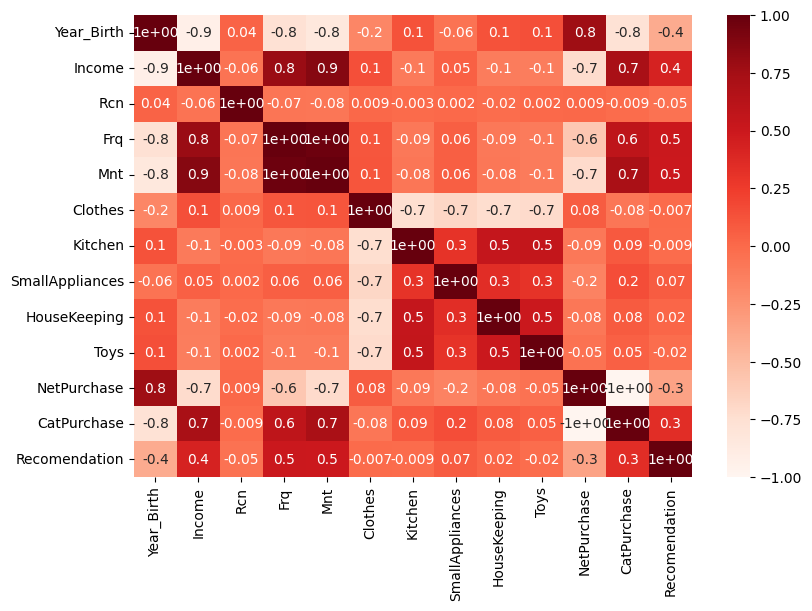

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


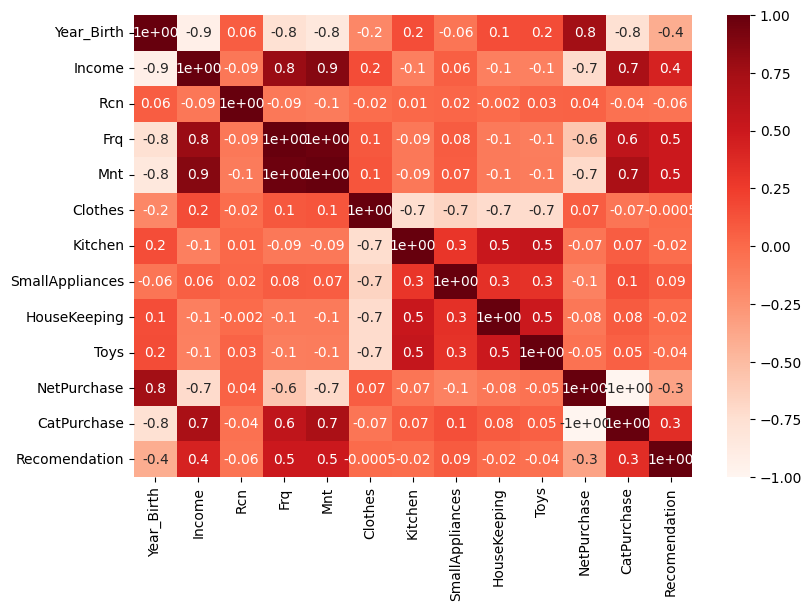

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


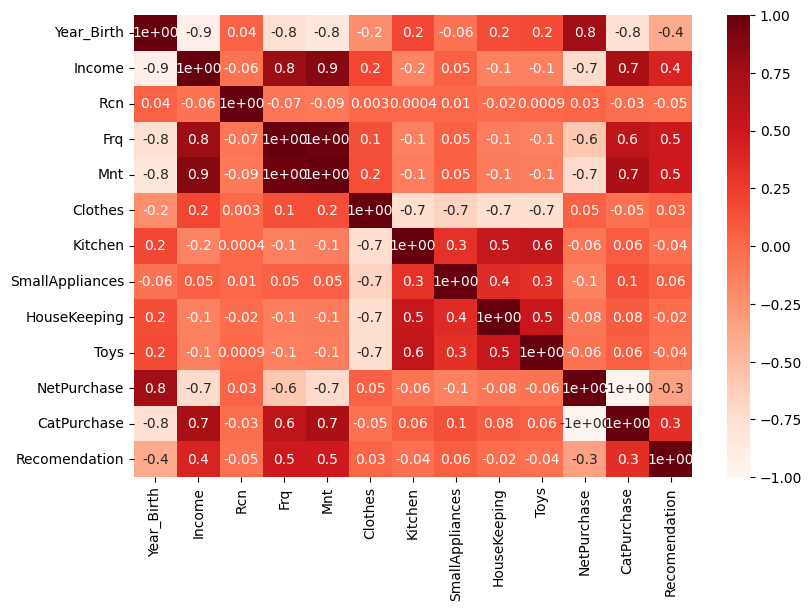

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


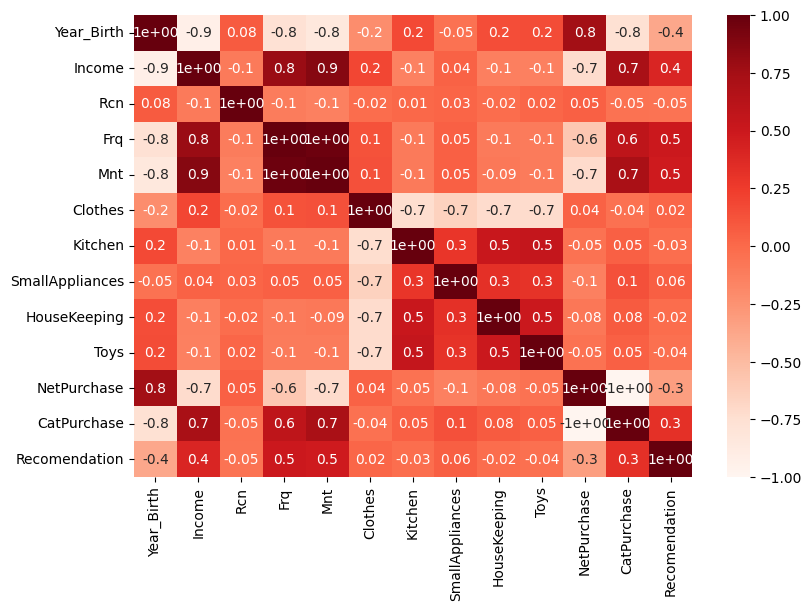

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


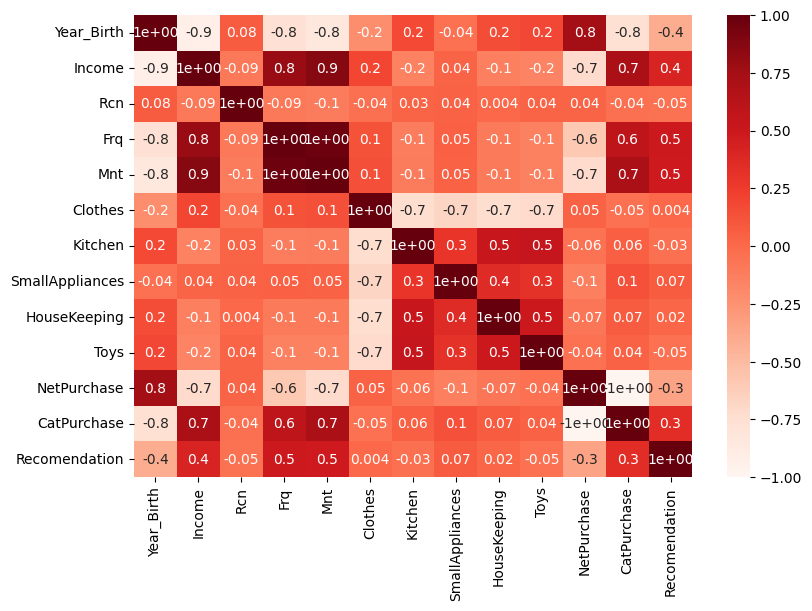

In [24]:
redundant_features(X, y)

### Redundant Variables - Spearman Correlation (Correlation higher than |0.8|)

| Combination | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 |
| --- | --- | --- | --- | --- | --- |
| Year_Birth Vs Income | -0.9 | -0.9 | -0.9 | -0.9 | -0.9 |
| Year_Birth Vs Frq | -0.8 | -0.8 | -0.8 | -0.8 | -0.8 |
| Year_Birth Vs Mnt | -0.8 | -0.8 | -0.8 | -0.8 | -0.8 |
| Year_Birth Vs NetPurchase | 0.8 | 0.8 | 0.7 | 0.8 | 0.8 |
| Year_Birth Vs CatPurchase | -0.8 | -0.8 | -0.7 | -0.8 | -0.8 |
| Income Vs Frq | 0.8 | 0.8 | 0.8 | 0.8 | 0.8 |
| Income Vs Mnt | 0.9 | 0.9 | 0.9 | 0.9 | 0.9 |
| __Frq Vs Mnt__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ |
| __NetPurchase Vs CatPurchase__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ |


In this case, we can see that there are high correlations within two groups of variables:
- Year_Birth, Income, Frq, Mnt
- NetPurchase, CatPurchase, Year_Birth

Now it is time to understand the ones that we should keep and the ones to be removed. <br>

The remaining methods that we are going to apply  for feature selection are: 
- __Wrapper methods__ - RFE
- __Embedded Methods__ - Lasso Regression and Decision Trees

It is important to note that regression models are particularly sensible to correlated features. Therefore, we will begin by applying decision trees to identify which features among the correlated ones should be excluded. 

Once we have eliminated the correlated features, we can proceed with techniques that involve regression models, such as RFE (using Logistic Regression) and Lasso Regression.



<a class="anchor" id="10th-bullet">

__`3.1.2.3. Decision Trees (Embedded Method) - For continuous, ordinal and binary data`__

</a>

Similarly to what we have done in the previous techniques, we will now examine the feature importance of the independent variables in the training data  using a decision tree, regardless of the specific train subset being used.

__`Step 17`__ - Create a function named as `plot_importance` that receives the feature importances and the name of the model being applied and: <br>
- Sort the feature importances using sort_values()
- create a figure with figsize=(4,5)  <br>
- plot an horizontal bar with the results <br>
- Add the title ("Feature importance using " and the name of the model)

In [25]:
def plot_importance(variables,name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(4,5))
    imp_features.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

__`Step 18`__ - Create a function named `apply_dt` that takes your training data as input (independent variables and target). In this function:
- Create a DecisionTreeClassifier with random_state = 99 and fit to your training data, Name it as `dt`
- Call the attribute from the model decision trees `feature_importances_` and store those results in a Pandas DataFrame.
- Call the previously defined function `plot_importance` to generate the horizontal bar with the feature importances provided by the decision tree.

In [26]:
def apply_dt(X_train, y_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(X_train, y_train)
    feature_importances = pd.Series(dt.feature_importances_, index = X_train.columns)
    plot_importance(feature_importances, 'DT')

__`Step 19`__ - Create a function named as `select_best_features_dt` that receives the independent variables (X) and the target (y). <br>
Inside of this function, follow these steps:<br>
- Apply the previously defined StratifiedKFold as "skf" for cross-validation.
- Fill missing data, focusing this time on the numerical variables.
- Drop the `Marital_Status`variable, since we are using the feature importance of decision trees to evaluate the numerical data.
- Call the `apply_dt` function on your data.

In [27]:
def select_best_features_dt(X, y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        # Fill missing values in training data
        X_train['Income'].fillna(X_train['Income'].median(), inplace = True)
        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using decision Tree
        X_train = X_train.drop(['Marital_Status'], axis = 1)
        apply_dt(X_train, y_train)
        
        count+=1

__`Step 19B`__ - Call your function `select_best_features_dt` passing as arguments your independent variables and your target.

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


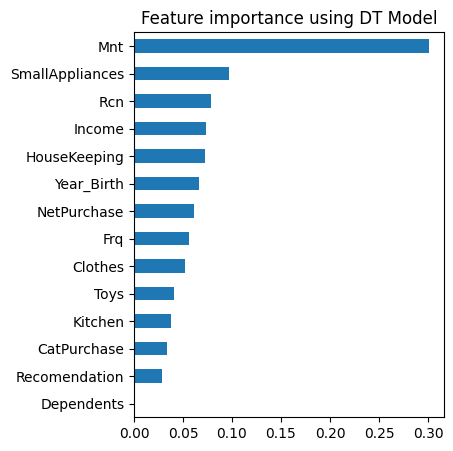

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


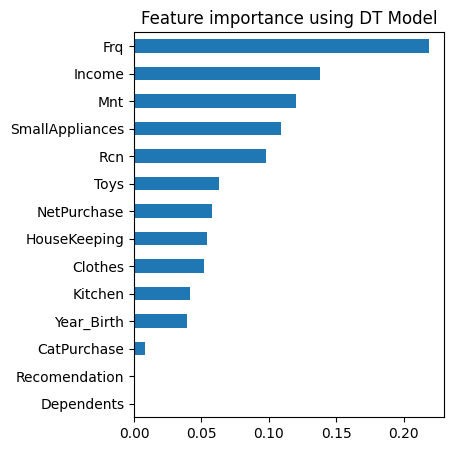

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


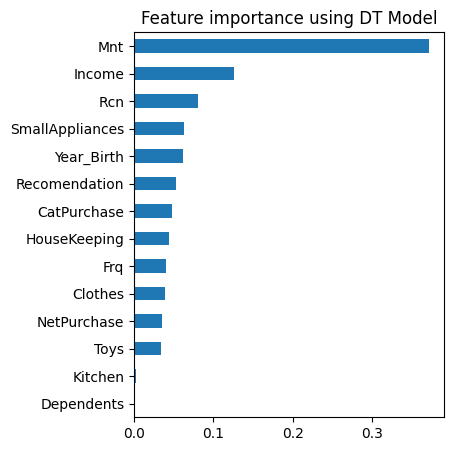

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


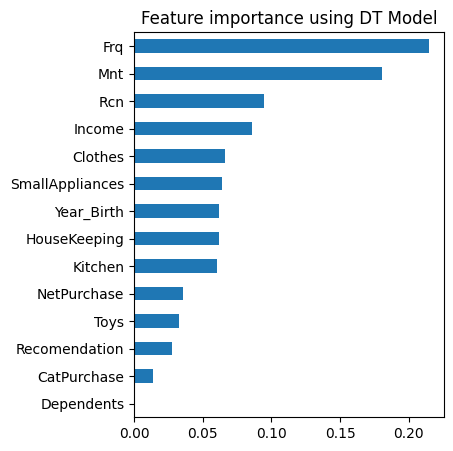

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


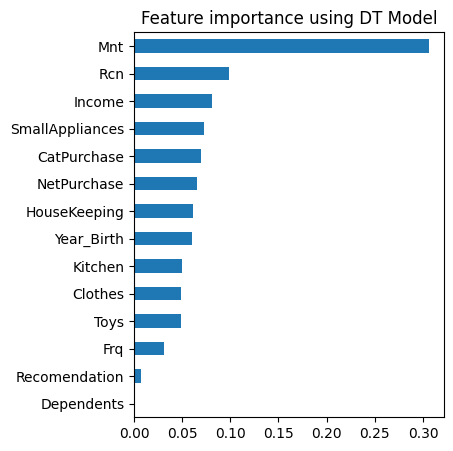

In [28]:
select_best_features_dt(X, y)

We had identified previously with correlation matrix that two groups of variables that seem to be highly correlated among them, namely:
- Year_Birth, Income, Frq, Mnt
- NetPurchase, CatPurchase, Year_Birth

From the first group, we are going to include only Mnt, the variable that according to decision trees feature importance appears three times as the most important one. We remove `Year_Birth`, `Income` and `Frq`.

From the second group (and not considering Year_birth since this variable have a high correlation with Mnt), we are going to keep NetPurchase, that appears always more important than CatPurchase except in the last split. We remove `CatPurchase`.


__`Step 20`__ - Remove the variables that were excluded by the combination of the results of the decision tree and the correlation matrix, namely `Income`, `Frq`, `CatPurchase` and `Year_Birth`.

In [29]:
X = X.drop(['Income','Frq','CatPurchase','Year_Birth'], axis = 1)

At this moment, you already removed correlated features and can apply techniques where regression is used.
 <br><br>
 To apply Lasso Regression and RFE (using Logistic Regression as an estimator), we should scale our data previously. <br>
 In the case of the Decision Trees, it is not needed - the results should be similar if data is scaled or not. <br><br>

<a class="anchor" id="11th-bullet">

__`3.1.2.4. Recursive Feature Elimination (RFE) (Wrapper Method) - For continuous, ordinal and binary data`__
    
</a>

__`Step 21`__ - Create a function named `apply_rfe` that takes your training data as input (independent variables and target). In this function:
- Create an instance of RFE named as `rfe`, where `estimator = LogisticRegression()` and `n_features_to_select = 5` 
- Apply the method `fit_transform()` from `rfe` to your training data.
- Call the attribute from the RFE named `support_` and store those results in a Pandas Series named `selected_features`.
- Print `selected_features`


In [30]:
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 5)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)
    print(selected_features)

<a class="anchor" id="12th-bullet">

__`3.1.2.5. Lasso - For continuous and ordinal data`__
    
</a>

__`Step 22`__ - Create a function named `apply_lasso` that takes your training data as input (independent variables and target). In this function:
- Remove the variable `Dependents` from the training data, since Lasso regression is not appropriate for binary data. 
- Create an instance of LogisticRegressionCV, and apply the method `fit()`to your training data.
- Call the attribute from the Lasso named `coef_` and store those results in a Pandas Series named `coef`. This will return the coefficients associated with each variable.
- Call the previously defined function `plot_importance` to generate the horizontal bar with the coefficients provided by the Lasso.

In [31]:
def apply_lasso(X_train, y_train):
    X_train = X_train.drop(['Dependents'], axis = 1)
    lasso = LogisticRegressionCV(penalty='l1', solver='saga').fit(X_train, y_train)
    coef = pd.Series(abs(lasso.coef_[0]), index = X_train.columns)
    plot_importance(coef,'Lasso')

Now it is time to apply the different techniques to our data to each partition, and get insights from it. We can also apply again Decision Trees to obtain our final results.


__`Step 23`__ - Create a function named as `select_best_features` that receives the independent variables (X) and the target (y). <br>
Inside of this function, follow these steps:<br>
- Apply the previously defined StratifiedKFold as "skf" for cross-validation.
- Drop the `Marital_Status`variable, since we are evaluating the numerical data.
- Apply MinMaxScaler to your training data.
- Call the `apply_rfe` function on your data.
- Call the `apply_lasso` function on your data. 
- Call the `apply_dt` function on your data.

In [32]:
def select_best_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ####################################### FILL MISSING DATA #################################################
        # Income was already been removed from our variables
        
        ########################################### SCALE DATA #################################################### 
        numerical_data = X_train.drop(['Marital_Status'], axis = 1).copy()
        scaler = MinMaxScaler().fit(numerical_data)
        X_train_scaled = scaler.transform(numerical_data)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_data.columns)
    
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # Check which features to use using RFE
        print('')
        print('----------------- RFE ----------------------')
        apply_rfe(X_train_scaled, y_train)
        
        # check which features to use using lasso
        print('')
        print('----------------- LASSO ----------------------')
        apply_lasso(X_train_scaled, y_train)
            
        # check which features to use using lasso
        print('')
        print('----------------- DT ----------------------')
        apply_dt(X_train_scaled, y_train)
            
        count+=1

__`Step 23B`__ - Call your function `select_best_features` passing as arguments your independent variables and your target.

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Dependents         False
Rcn                False
Mnt                 True
Clothes             True
Kitchen             True
SmallAppliances    False
HouseKeeping       False
Toys               False
NetPurchase         True
Recomendation       True
dtype: bool

----------------- LASSO ----------------------


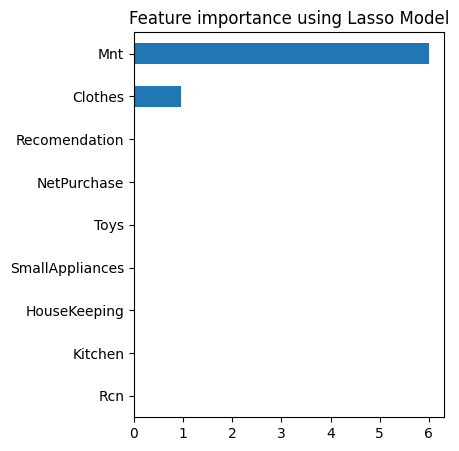


----------------- DT ----------------------


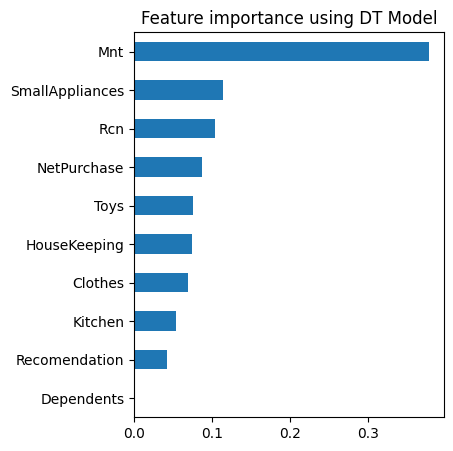

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Dependents          True
Rcn                False
Mnt                 True
Clothes             True
Kitchen            False
SmallAppliances    False
HouseKeeping       False
Toys               False
NetPurchase         True
Recomendation       True
dtype: bool

----------------- LASSO ----------------------


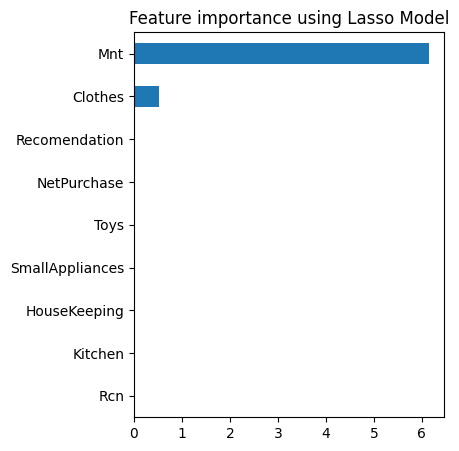


----------------- DT ----------------------


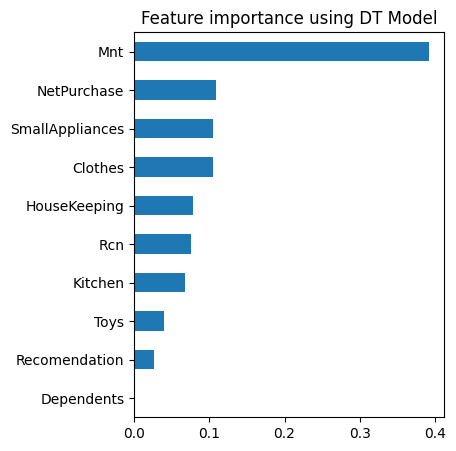

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Dependents          True
Rcn                False
Mnt                 True
Clothes             True
Kitchen            False
SmallAppliances    False
HouseKeeping       False
Toys               False
NetPurchase         True
Recomendation       True
dtype: bool

----------------- LASSO ----------------------


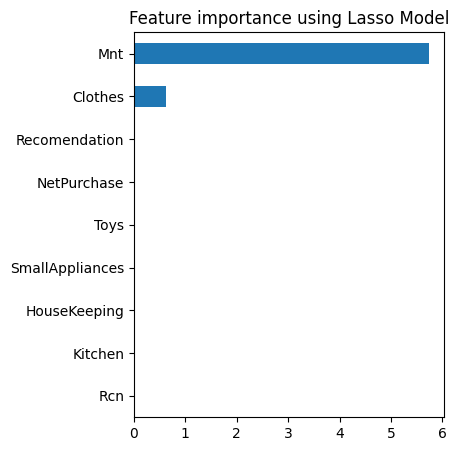


----------------- DT ----------------------


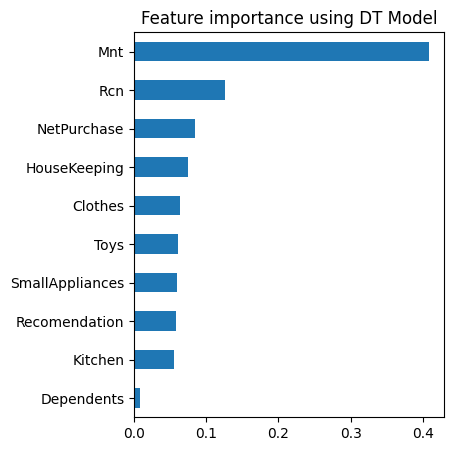

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Dependents         False
Rcn                False
Mnt                 True
Clothes             True
Kitchen            False
SmallAppliances    False
HouseKeeping        True
Toys               False
NetPurchase         True
Recomendation       True
dtype: bool

----------------- LASSO ----------------------


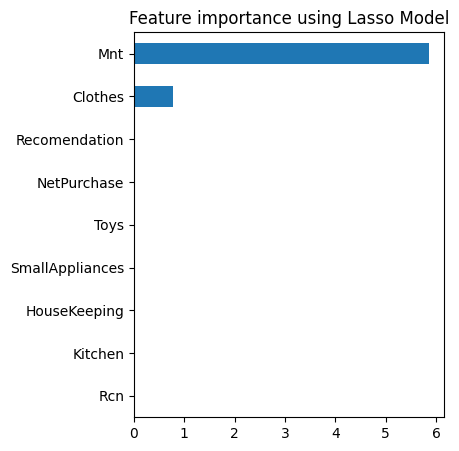


----------------- DT ----------------------


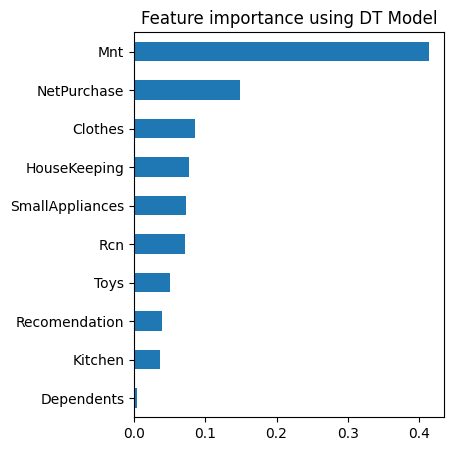

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Dependents         False
Rcn                False
Mnt                 True
Clothes             True
Kitchen             True
SmallAppliances    False
HouseKeeping       False
Toys                True
NetPurchase         True
Recomendation      False
dtype: bool

----------------- LASSO ----------------------


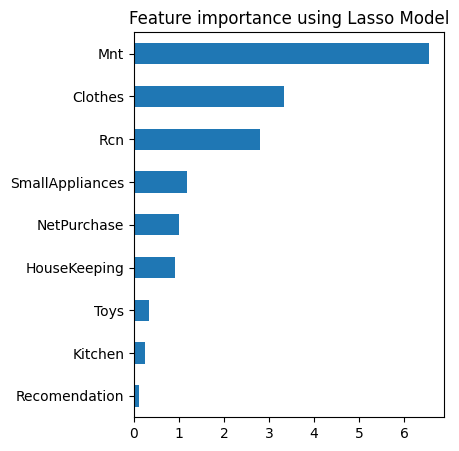


----------------- DT ----------------------


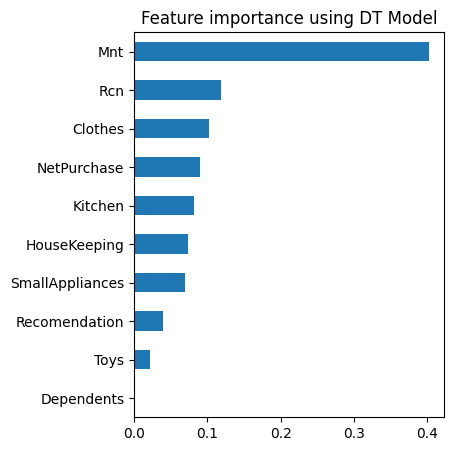

In [33]:
select_best_features(X, y)

At the end, you can combine the results you obtained previously to understand which features are the most important ones. <br>
In Decision Trees and in Lasso, we are going to select the the Top 5.

<hr>



### Numerical Data

`Which variables should we keep using this techniques?`

| Predictor | RFE | Lasso | DT | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- | --- |
Dependents      | 3 YES | X | 0 YES |REMOVE |
Rcn             | 0 YES | 1 YES | 3 YES | Try with and without |
Mnt             | 5 YES | 5 YES | 5 YES | KEEP |
Clothes         | 5 YES | 5 YES | 4 YES | KEEP |
Kitchen         | 2 YES | 0 YES | 1 YES | REMOVE |
SmallAppliances | 0 YES | 1 YES | 4 YES | Try with and Without |
HouseKeeping    | 1 YES | 0 YES | 2 YES | REMOVE |
Toys            | 1 YES | 0 YES | 1 YES | REMOVE |
NetPurchase     | 5 YES | 1 YES | 5 YES | KEEP |
Recomendation   | 4 YES | 0 YES | 0 YES | Try with and Without |
CostPerContact | | | | REMOVE - Constant Feature|
RevenuePerPositiveAnswer | | | | REMOVE - Constant Feature|
Income | | | | REMOVE (Highly correlated with Mnt) |
Frq | |  | | REMOVE (Highly Correlated with Mnt) |
CatPurchase | |  | | REMOVE (Highly Correlated with NetPurchase) |

<hr>


At this stage, we can identify certain variables that appear to be more important to retain, specifically `Mnt`, `Clothes`, `NetPurchase` and `Marital_Status`.

However, there are other variables for which we are less certain about their significance: `Rcn`, `SmallAppliances`, `Toys`, and `Recomendation`.

__`Step 24`__ Let's create two datasets:
- One dataset that includes the variables that we are certain are important (name it as `keep_data`):
    - Variables: Mnt, Clothes, NetPurchase, Marital_Status, DepVar <br><br>
- Another dataset that includes the variables that are both important and those we are unsure about at this point (name it as `all_data`):
    - Variables: Mnt, Clothes, NetPurchase, Rcn, SmallAppliances, Toys, Recomendation, Marital_Status, DepVar

In [34]:
keep_data = data[['Mnt','Clothes','NetPurchase','Marital_Status','DepVar']].copy()
all_data = data[['Mnt','Clothes','NetPurchase','Rcn','SmallAppliances','Recomendation','Marital_Status','DepVar']].copy()

In [35]:
keep_data.to_csv('keep_data.csv')
all_data.to_csv('all_data.csv')

<a class="anchor" id="">

# 4 & 5. Model & Assess (Modelling and Assessment)

</a>
<img src="Images/step4.png" style="height:70px">

### 4.1. Model Selection

In this section you should take the time to train different predictive algorithms with the data that got to this stage and **use the approppriate model assessment metrics to decide which model you think is the best to address your problem**.

**You are expected to present on your report the model performances of the different algorithms that you tested and discuss what informed your choice for a specific algorithm**

In [36]:
# Next Class

### 4.2. Model Optimization

After selecting the best algorithm (set of algorithms), you can try to optimize the performance of your model by fiddling with the algorithms' hyper-parameters and select the options that result on the best overall performance.

Possible ways of doing this can be through:
1. [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
2. [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)


In [37]:
# Next Class

<a class="anchor" id="">

# 5. Deploy

</a>
<img src="Images/step5.png" style="height:70px">


### 5.0 Training a final model

You used the previous steps of modelling and assessment to determine what would be best strategies when it comes to preprocessing, scaling, feature selection, algorithm and hyper-parameters you could find. 

**By this stage, all of those choices were already made**. For that reason, a split between training and validation is no longer necessary. **A good practice** would be to take the initial data and train a final model with all of the labeled data that you have available.

**Everything is figured by this stage**, so, on a first level all you need to do is replicate the exact preprocessing, scaling and feature selection decisions you made before.<br>
When it comes to the final model, all you have to do is creeate a new instance of your best algorithm with the best parameters that you uncovered (no need to try all algorithms and hyper-parameters again).

### 5.1. Import and Transform your test data

Remember, the test data does not have the `outcome` variable.

In [38]:
# Next Class

### 5.2. Obtain Predictions on the test data from your final model

In [39]:
# Next Class

### 5.3. Create a Dataframe containing the index of each row and its intended prediction and export it to a csv file

In [40]:
# Next Class